In [0]:
%pip install sktime==0.19.1 pmdarima==2.0.3 

Python interpreter will be restarted.
  Using cached sktime-0.19.1-py3-none-any.whl (17.0 MB)
  Using cached pmdarima-2.0.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.9 MB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl (9.6 kB)
  Using cached scikit_base-0.4.5-py3-none-any.whl (117 kB)
  Using cached numpy-1.24.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached statsmodels-0.14.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.1 MB)
  Using cached wrapt-1.15.0-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (78 kB)
  Using cached numpy-1.22.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sktime.forecasting.arima import AutoARIMA

In [0]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  A problem might be the first and the last data-point. It happend that
  they were substancially different then the rest and therefor need a fix.

  As a simple fix i will just reassigne the first and the last value to the value of their neighbours.
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf.at[pdf.index[0],column]   = pdf[column].iloc[1]

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2]

  return pdf

In [0]:
url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"

pdf = pd.read_csv(url,index_col=None)

pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])
pdf = resample_fix_ends(pdf,"W")

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings
split = int(len(pdf)*0.8)

pdf = pdf.drop(columns=["Value_NE5"])
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

pdf

               Value_NE5     Value_NE7
Timestamp                             
2015-01-04  1.836663e+07  3.903323e+07
2015-01-11  1.836663e+07  3.903323e+07
2015-01-18  1.845451e+07  3.932494e+07
2015-01-25  1.888946e+07  4.011272e+07
2015-02-01  1.896061e+07  3.987419e+07
...                  ...           ...
2023-05-07  1.562128e+07  3.005138e+07
2023-05-14  1.612559e+07  3.184512e+07
2023-05-21  1.536619e+07  3.074290e+07
2023-05-28  1.615398e+07  3.061727e+07
2023-06-04  1.403147e+07  2.579984e+07

[440 rows x 2 columns]


,Value_NE7
Timestamp,
2015-01-04,3.903323e+07
2015-01-11,3.903323e+07
2015-01-18,3.932494e+07
2015-01-25,4.011272e+07
2015-02-01,3.987419e+07
...,...
2023-05-07,3.005138e+07
2023-05-14,3.184512e+07
2023-05-21,3.074290e+07


In [0]:

arima = AutoARIMA(sp=52,suppress_warnings=True,
                       stationary=False,seasonal=True, n_jobs=5)
arima.fit(pdf_train["Value_NE7"]) 

print(arima.get_fitted_params())

/local_disk0/.ephemeral_nfs/envs/pythonEnv-a1f8b284-af88-45e2-b16b-35570565589a/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
{'ma.L1': -0.053781359290679516, 'ma.L2': -0.06961046567183381, 'ar.S.L52': 0.13816901747220503, 'sigma2': 2008960924063.5388, 'order': (0, 1, 2), 'seasonal_order': (1, 0, 0, 52), 'aic': 10944.518075071062, 'aicc': 10944.63368200748, 'bic': 10959.961219964925, 'hqic': 10950.664345170391}


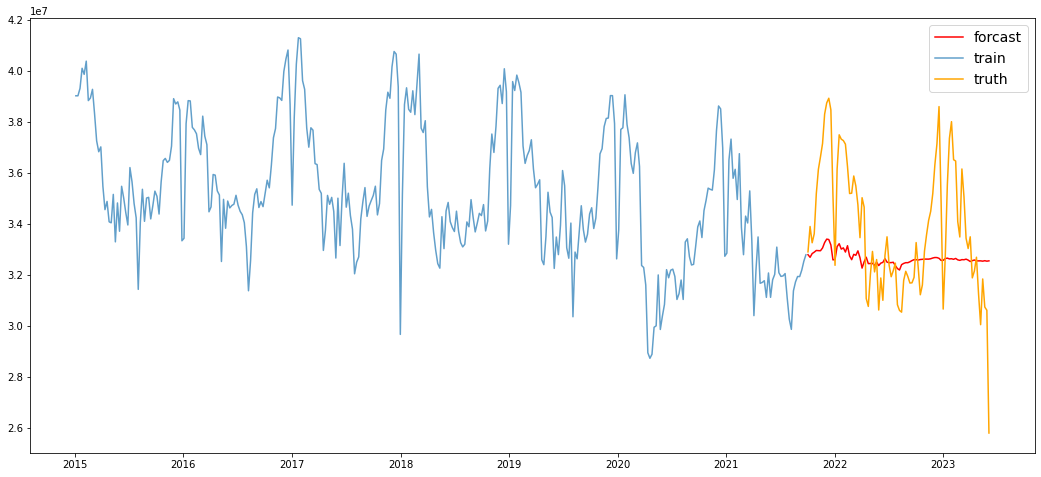

In [0]:
plt.figure(figsize=(18, 8))

plt.plot(pdf_test.index,arima.predict(pdf_test.index), color="red", label="forcast")
plt.plot(pdf_train, alpha=0.7, label="train")
plt.plot(pdf_test, color="orange", label="truth")

#plt.ylim(1e7,3e7)
plt.legend(fontsize=14)
plt.show()

In [0]:
# {'ma.L1': -0.10269580896932338,
#  'ma.L2': -0.05776921664292152,
#  'ar.S.L52': 0.6667060061212048,
#  'ma.S.L52': -0.5152996430575411,
#  'sigma2': 441495342454.9014,
#  'order': (0, 1, 2),
#  'seasonal_order': (1, 0, 1, 52),
#  'aic': 10347.969665152114,
#  'aicc': 10348.144592265817,
#  'bic': 10367.245024763126,
#  'hqic': 10355.642747960801}